In [13]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import Pk_library as PKL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('./style.mcstyle')

import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from cmass.utils import load_params
lhid = 3
BoxSize=1000.0
wdir = '/home/mattho/git/ltu-cmass/data/'
cdir = wdir+f'quijotelike/fastpm/L1000-N128/{lhid}'
qdir = wdir+f'quijote/nbody/L1000-N128/{lhid}'
cosmo = load_params(lhid, '../params/latin_hypercube_params.txt')

In [34]:
# Load ltu-cmass

with h5py.File(join(cdir, 'nbody.h5'), 'r') as f:
    a = list(f.keys())[-1]
    r = f[a]['rho'][...]
with h5py.File(join(cdir, 'transfer.h5'), 'r') as f:
    ric = f['rho'][...]

In [35]:
# Load FastPM

import pickle

# lhid=3
fdir = '/home/mattho/git/ltu-cmass/data/scratch/fastpm'
filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=99_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rho_IC = d['density_cic_unpad_combined']

filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rho = d['density_cic_unpad_combined']
print(rho_IC.shape, rho.shape)

(128, 128, 128) (128, 128, 128)


In [36]:
# Load Quijote

snapnum = lhid
isim_fid = lhid
mass_type = 'rockstar_200c'
snap_dir_base = '/home/mattho/data/quijote/Halos/Rockstar/latin_hypercube_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h


# Conform
qmass = np.log10(mass_truth)
mask = qmass > 13
qmass = qmass[mask]
qpos = pos_h_truth[mask]


/tmp/ipykernel_3430369/3925180877.py:23: RuntimeWarning: divide by zero encountered in log10
  qmass = np.log10(mass_truth)


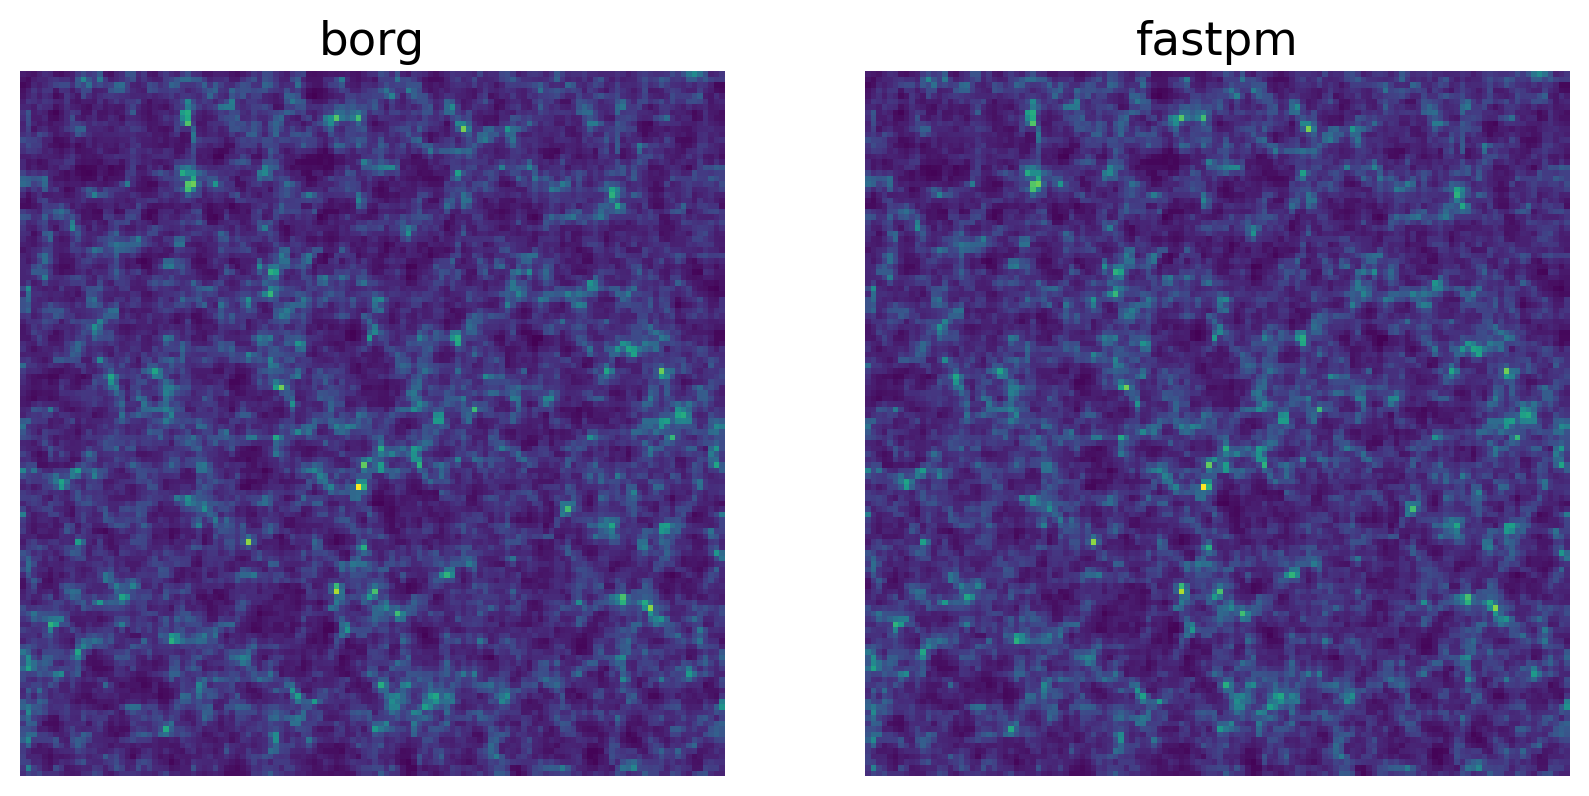

In [37]:
f, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(np.mean(r[50:60], axis=0))
axs[0].set_title('borg')
axs[1].imshow(np.mean(rho[50:60], axis=0))
axs[1].set_title('fastpm')
for ax in axs:
    ax.axis('off')


Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


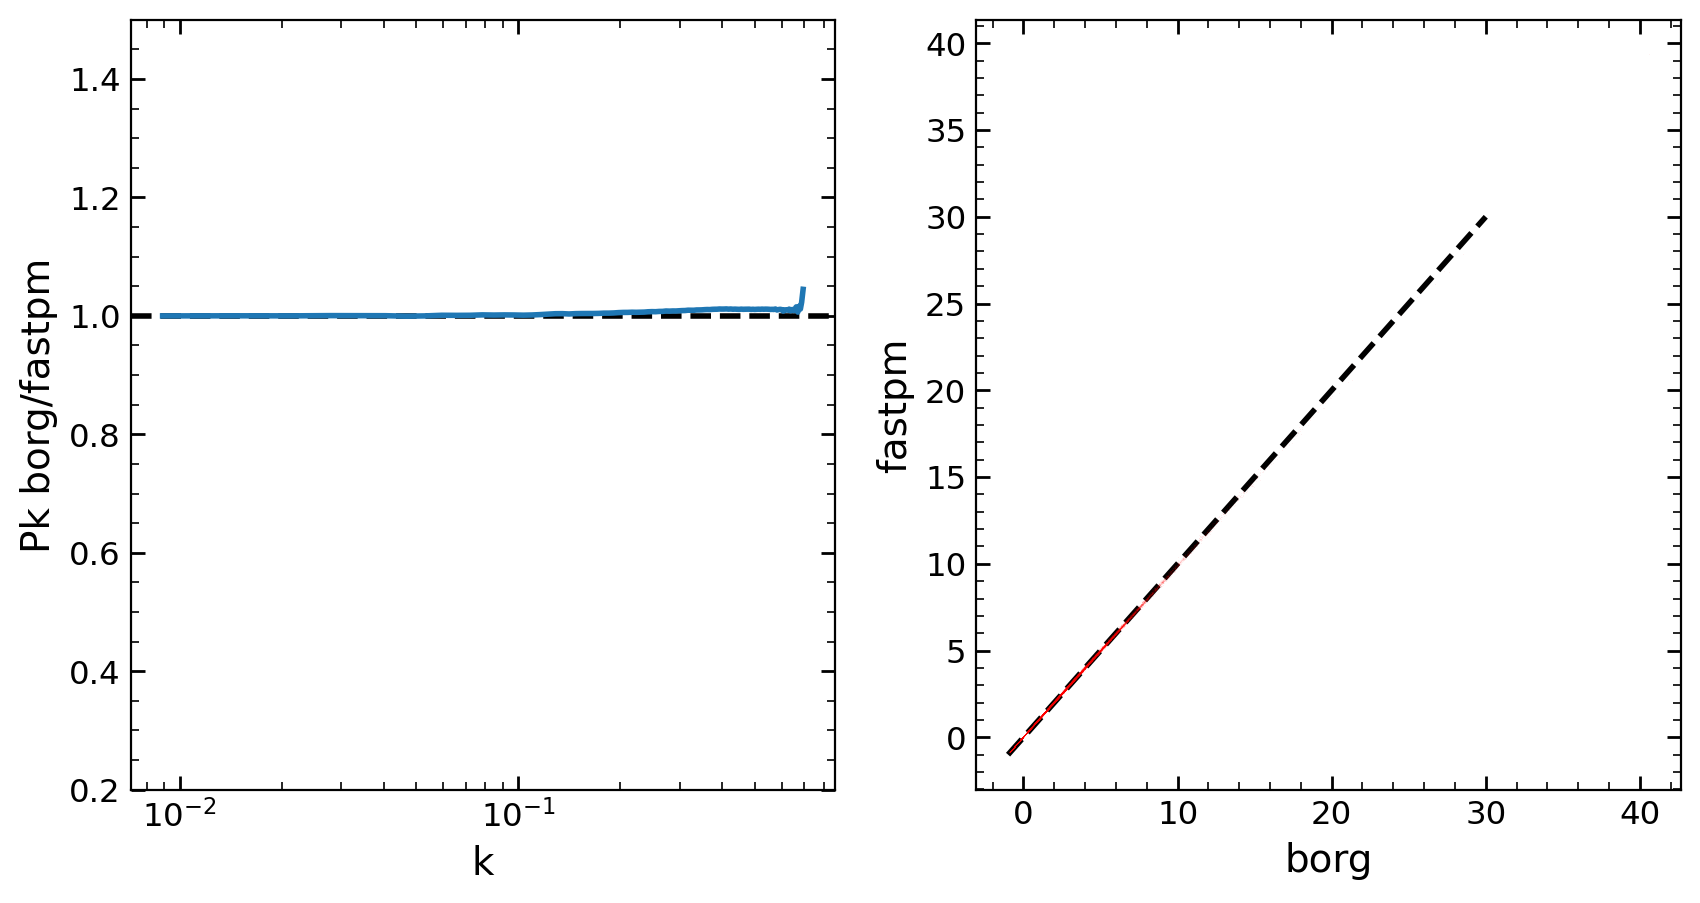

In [38]:
f, axs = plt.subplots(1,2, figsize=(10,5))

Pk_h_fastpm = PKL.Pk(rho.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
Pk_h_borg = PKL.Pk(r.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
axs[0].semilogx()
axs[0].axhline(1, color='k', ls='--')
axs[0].plot(Pk_h_fastpm.k3D, Pk_h_borg.Pk[:,0]/Pk_h_fastpm.Pk[:,0], label='fastpm')
axs[0].set(xlabel='k', ylabel='Pk borg/fastpm')
axs[0].set_ylim(0.2, 1.5)

x_ = np.linspace(-1,30, 100)
axs[1].plot(x_, x_, 'k--')
axs[1].plot(r.flatten(), rho.flatten(), 'r,', alpha=0.05)
axs[1].set(xlabel='borg', ylabel='fastpm');

Text(0.5, 1.0, 'fastpm')

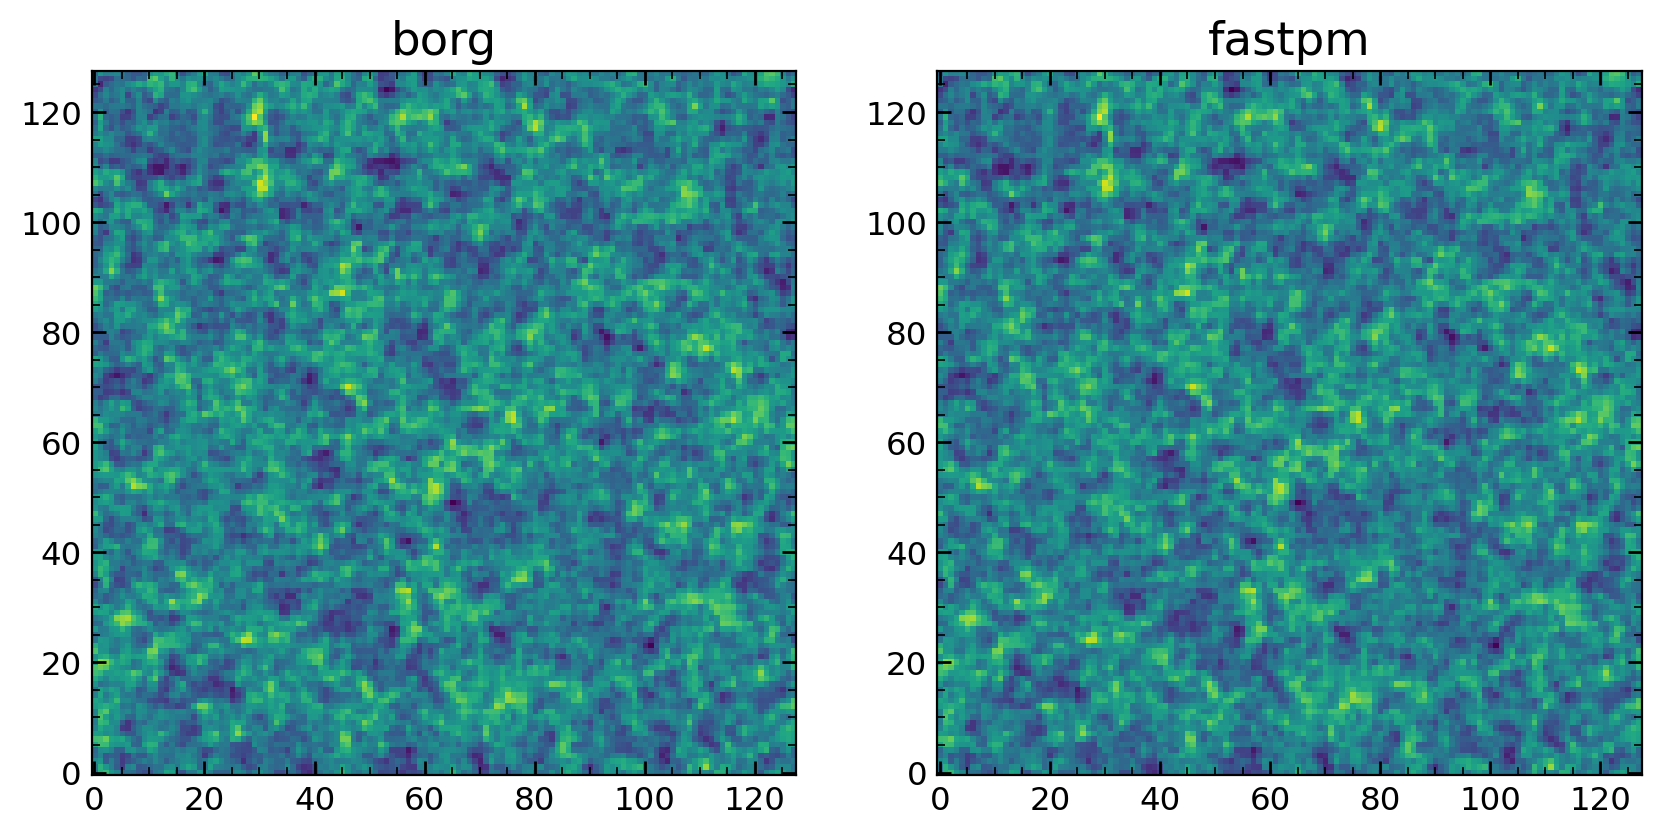

In [39]:
f, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(np.mean(ric[50:60], axis=0))
axs[0].set_title('borg')
axs[1].imshow(np.mean(rho_IC[50:60], axis=0))
axs[1].set_title('fastpm')


Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


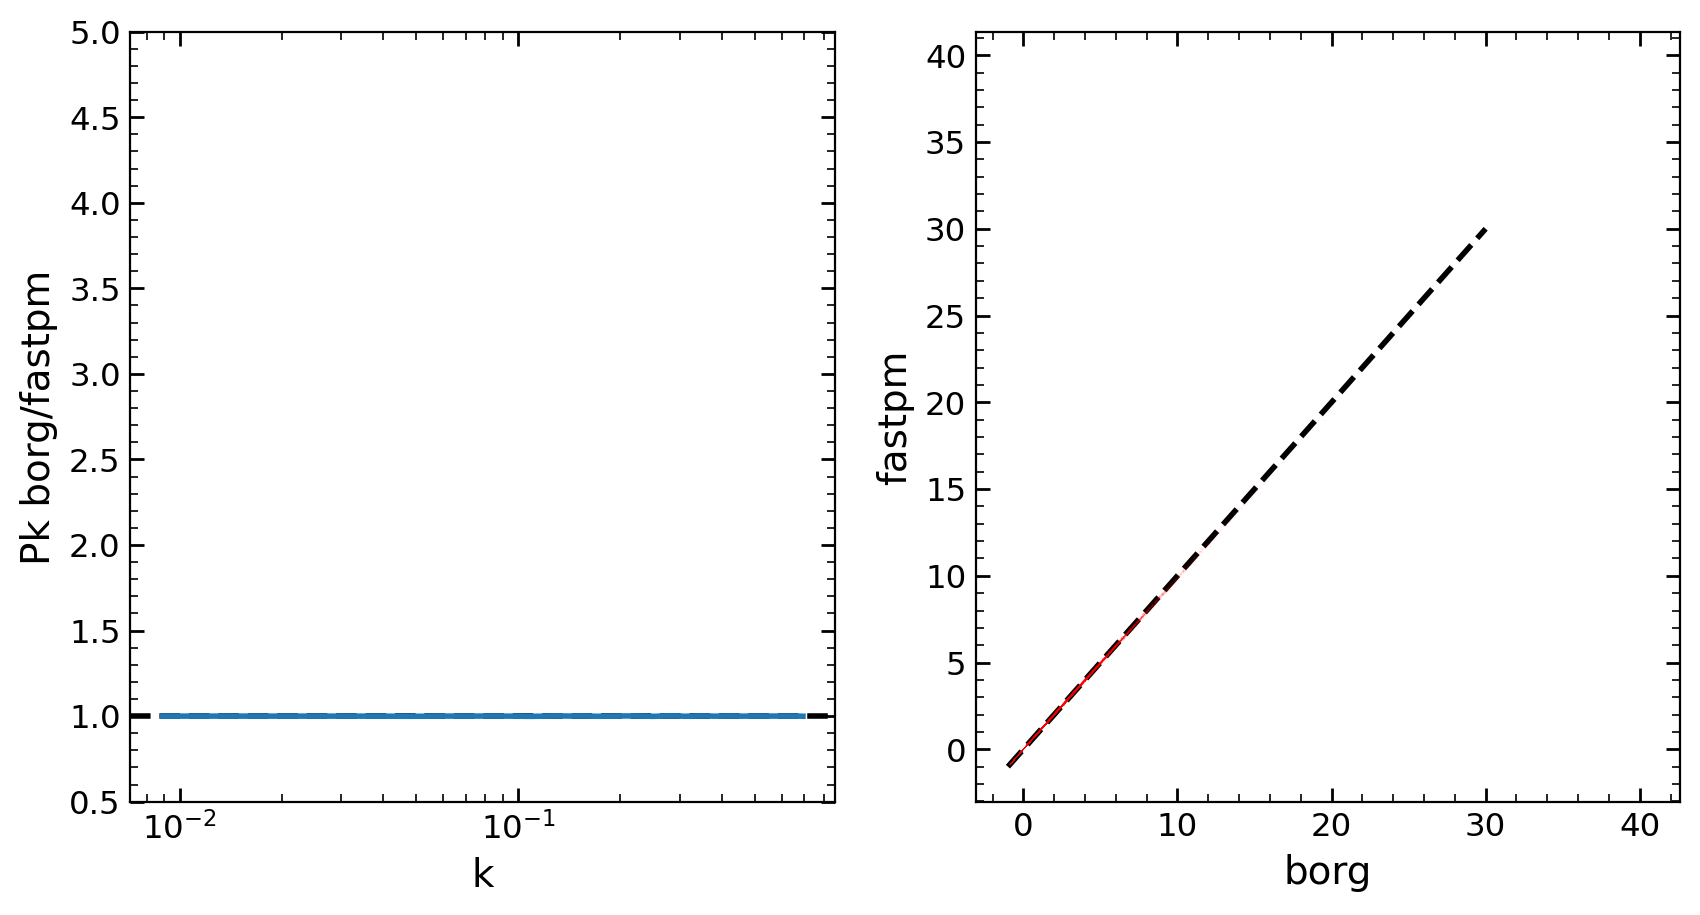

In [40]:
f, axs = plt.subplots(1,2, figsize=(10,5))

Pk_h_fastpm = PKL.Pk(rho_IC.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
Pk_h_borg = PKL.Pk(ric.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
axs[0].semilogx()
axs[0].axhline(1, color='k', ls='--')
axs[0].plot(Pk_h_fastpm.k3D, Pk_h_borg.Pk[:,0]/Pk_h_fastpm.Pk[:,0], label='fastpm')
axs[0].set(xlabel='k', ylabel='Pk borg/fastpm')
axs[0].set_ylim(0.5, 5)

x_ = np.linspace(-1,30, 100)
axs[1].plot(x_, x_, 'k--')
axs[1].plot(r.flatten(), rho.flatten(), 'r,', alpha=0.05)
axs[1].set(xlabel='borg', ylabel='fastpm');

In [45]:
# Run charm

from cmass.bias.charm.integrate_ltu_cmass import get_model_interface
run_config_name = 'config_v0.yaml'
charm_interface = get_model_interface(run_config_name)

cpars = cosmo
hpos, hmass = charm_interface.process_input_density(
    r, # rho,
    ric, # rho_IC, # ric*0.7,
    cosmology_array=np.array(cpars)
)
mask = hmass > 13
hpos = hpos[mask]
hmass = hmass[mask]


loading bestfit model
-34.86669921875 20278


In [49]:
# Load charm halos from file
with h5py.File(join(cdir, 'halos.h5'), 'r') as f:
    a = list(f.keys())[-1]
    hpos = f[a]['pos'][...]
    hvel = f[a]['vel'][...]
    hmass = f[a]['mass'][...]


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


Text(0, 0.5, 'Cross Power Spectrum')

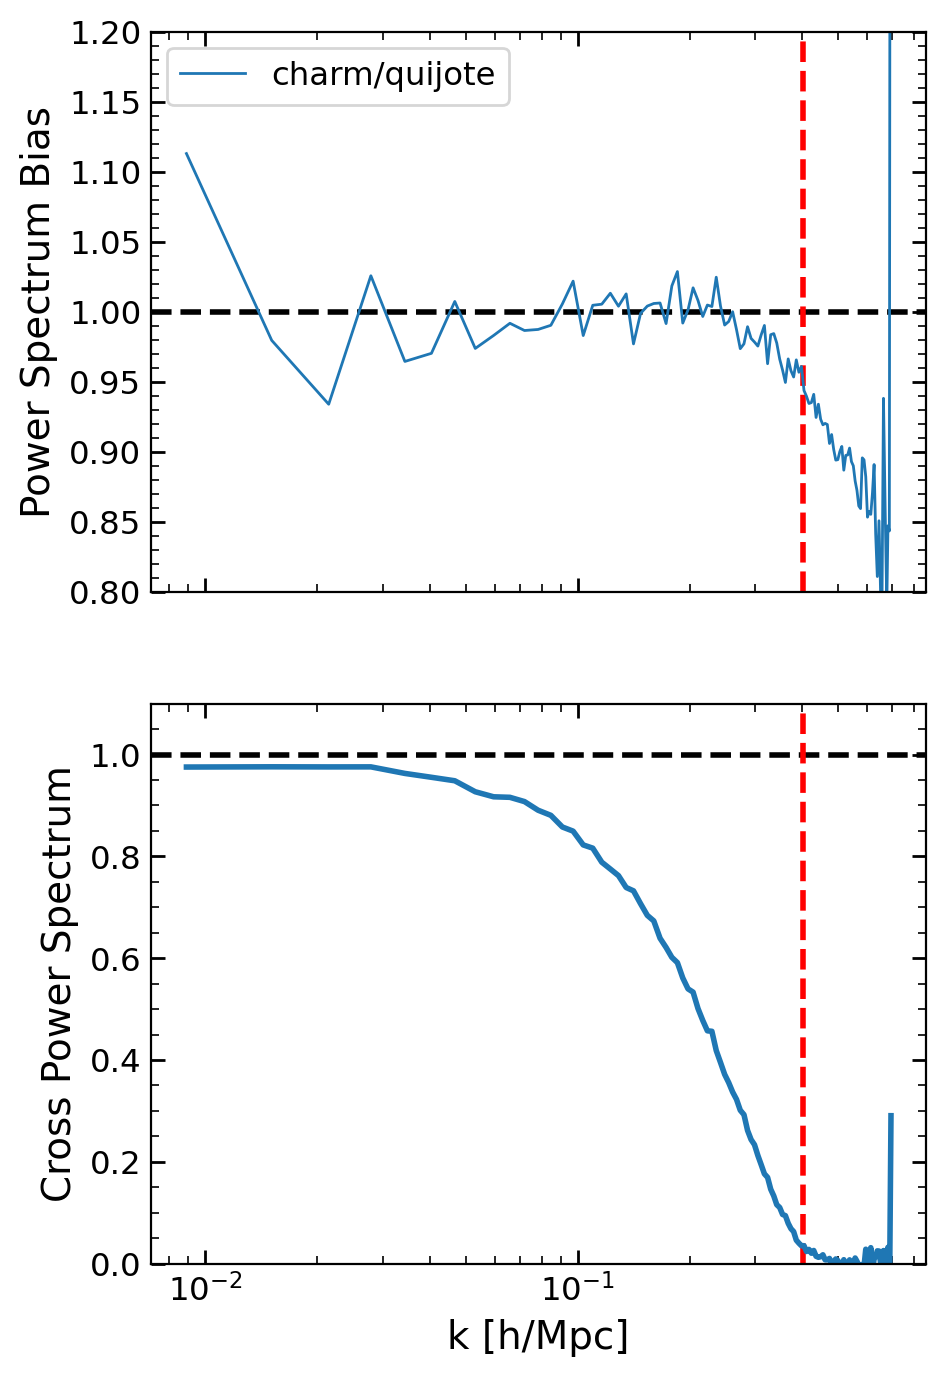

In [50]:
import Pk_library as PKL

cH, _ = np.histogramdd(hpos, bins=128, range=[[0,1000]]*3)
qH, _ = np.histogramdd(qpos, bins=128, range=[[0,1000]]*3)
cH, qH = map(lambda x: x.astype(np.float32), [cH, qH])

cH /= cH.mean()
qH /= qH.mean()
cH -= 1
qH -= 1

Pk = PKL.XPk([cH,qH], 1000, 0, MAS=['NGP','NGP'], threads=1)

f, axs = plt.subplots(2, 1, figsize=(5,8), sharex=True)

nyq =  2*np.pi/1000*(128/2)

# Pk
ax = axs[0]
k = Pk.k3D
ax.semilogx()
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k, (Pk.Pk[:,0,0]/Pk.Pk[:,0,1]), lw=1, label='charm/quijote')
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('Power Spectrum Bias')

ax.legend()

# XPk
ax = axs[1]
ax.semilogx()
k = Pk.k3D
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k, Pk.XPk[:,0,0]/np.sqrt(Pk.Pk[:,0,0]*Pk.Pk[:,0,1]), 
        label='fastPM-quijote')
ax.set_ylim(0., 1.1)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('Cross Power Spectrum')